In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

from scipy.signal import fftconvolve
from scipy.ndimage import gaussian_filter
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.signalprocessing     import slope_estimate
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.avo.poststack              import *

from pylops.signalprocessing.Seislet import _predict_trace

# Synthetic data

## Slope-oriented data creation

Data creation

In [2]:
np.random.seed(0)

In [3]:
# reflectivity model
nx, nt = 2**7, 121
dx, dt = 4, 0.004
x, t = np.arange(nx)*dx, np.arange(nt)*dt

layers = np.cumsum(np.random.uniform(2, 20, 40).astype(np.int))
layers =layers[layers<nt]
nlayers = len(layers)

k = np.tan(np.deg2rad(45))
ai = 1500 * np.ones(nt)
for top, base in zip(layers[:-1], layers[1:]):
    ai[top:base] = np.random.normal(2000, 200)
    
refl = np.pad(np.diff(ai), (0, 1))
refl[-30:] = 0

# wavelet
ntwav = 41
f0 = 30
wav = pylops.utils.wavelets.ricker(np.arange(ntwav)*0.004, f0)[0]
wavc = np.argmax(wav)

# trace
trace = np.convolve(refl, wav, mode='same')

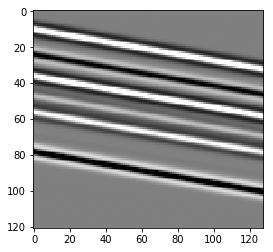

In [4]:
theta = np.linspace(10, 10, nx)
slope = np.outer(np.ones(nt), np.deg2rad(theta) * dt / dx)
d = np.zeros((nt, nx))
tr = trace.copy()
for ix in range(nx):
    tr = _predict_trace(tr, t, dt, dx, slope[:, ix])
    d[:, ix] = tr
plt.figure()
plt.imshow(d, cmap='gray', vmin=-200, vmax=200);

## Slope estimation

In [5]:
slope_est = -slope_estimate(d, dt, dx, smooth=7)[0]

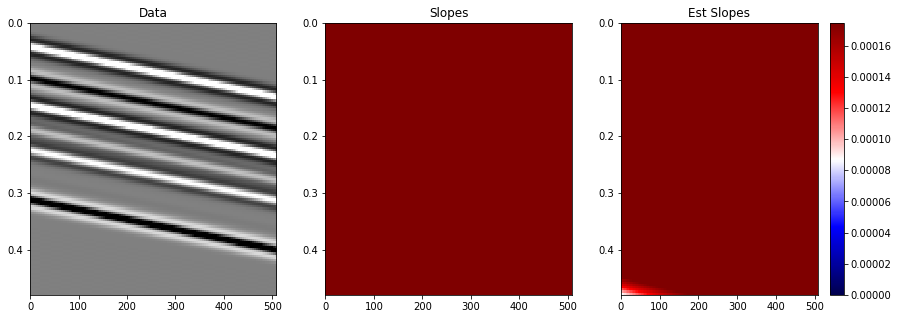

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(d, cmap='gray', vmin=-200, vmax=200,
              extent = (x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(slope, cmap='seismic', vmin=0, vmax=slope.max(),
              extent = (x[0], x[-1], t[-1], t[0]))
axs[1].set_title('Slopes')
axs[1].axis('tight')
im = axs[2].imshow(slope_est, cmap='seismic', vmin=0, vmax=slope.max(),
                   extent = (x[0], x[-1], t[-1], t[0]))
axs[2].set_title('Est Slopes')
axs[2].axis('tight')
plt.colorbar(im, ax=axs[2]);

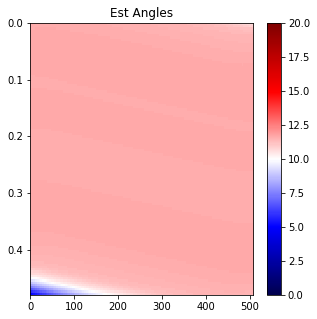

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.imshow(np.rad2deg(slope_est)*dx/dt, cmap='seismic', vmin=0, vmax=20,
              extent = (x[0], x[-1], t[-1], t[0]))
ax.set_title('Est Angles')
ax.axis('tight')
plt.colorbar(im, ax=ax);

## Seislet transform

In [8]:
Sop = Seislet(slope.T, sampling=(dx, dt), level=None)
S1op = Seislet(slope_est.T, sampling=(dx, dt), level=None)

dottest(Sop, nt*nx, nt*nx, verb=True);

Dot test passed, v^T(Opu)=-42.662065 - u^T(Op^Tv)=-42.662065


In [9]:
seis = Sop * d.T.ravel()
drec = Sop.inverse(seis)

seis1 = S1op * d.T.ravel()
drec1 = S1op.inverse(seis1)

seis = seis.reshape(nx, nt).T
seis1 = seis1.reshape(nx, nt).T
drec = drec.reshape(nx, nt).T
drec1 = drec1.reshape(nx, nt).T

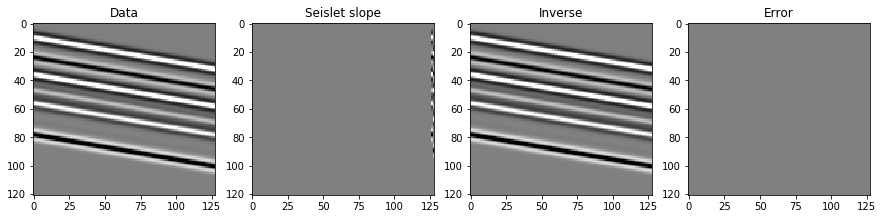

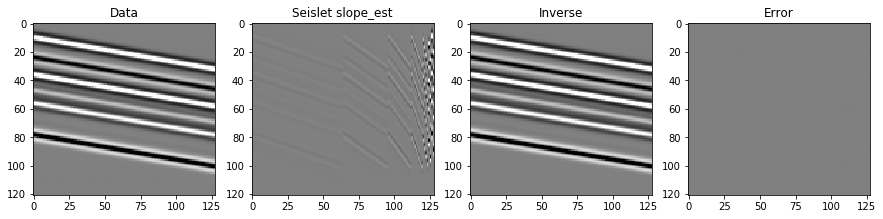

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(d, cmap='gray', vmin=-200, vmax=200)
axs[0].set_title('Data')
axs[1].imshow(seis, cmap='gray', vmin=-200, vmax=200)
axs[1].set_title('Seislet slope')
axs[2].imshow(drec, cmap='gray', vmin=-200, vmax=200)
axs[2].set_title('Inverse')
axs[3].imshow(d-drec, cmap='gray', vmin=-200, vmax=200)
axs[3].set_title('Error');

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(d, cmap='gray', vmin=-200, vmax=200)
axs[0].set_title('Data')
axs[1].imshow(seis1, cmap='gray', vmin=-200, vmax=200)
axs[1].set_title('Seislet slope_est')
axs[2].imshow(drec1, cmap='gray', vmin=-200, vmax=200)
axs[2].set_title('Inverse')
axs[3].imshow(d-drec1, cmap='gray', vmin=-200, vmax=200)
axs[3].set_title('Error');

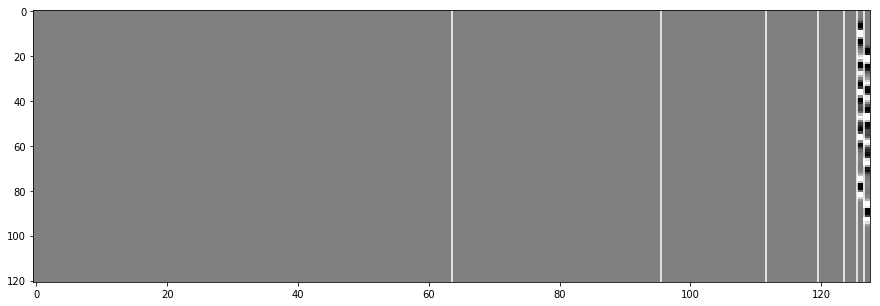

In [11]:
nlevels_max = int(np.log2(nx))
levels_size = np.flip(np.array([2 ** i for i in range(nlevels_max)]))
levels_cum = np.cumsum(levels_size)

plt.figure(figsize=(15, 5))
plt.imshow(seis, cmap='gray', vmin=-100, vmax=100)
for level in levels_cum:
    plt.axvline(level-0.5, color='w')
plt.axis('tight');

# Claerbout's data

In [12]:
inputfile='../data/sigmoid.npz'

d = np.load(inputfile)
d = d['sigmoid']
nx, nt = d.shape
dx, dt = 8, 0.004
x, t = np.arange(nx) * dx, np.arange(nt) * dt

# slope estimation
slope = -slope_estimate(d.T, dt, dx, smooth=6)[0]

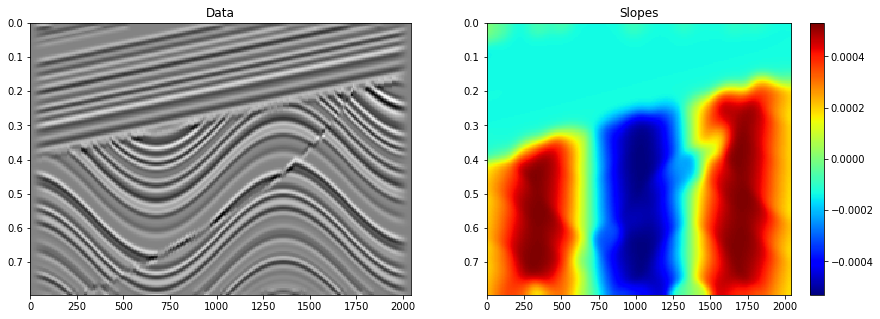

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(d.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Data')
axs[0].axis('tight')
im = axs[1].imshow(slope, cmap='jet', vmin=slope.min(), vmax=-slope.min(),
              extent = (x[0], x[-1], t[-1], t[0]))
axs[1].set_title('Slopes')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1]);

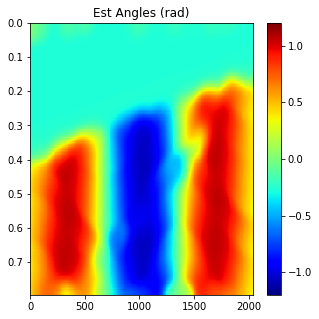

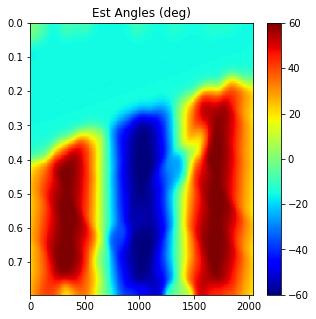

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.imshow(slope*dx/dt, cmap='jet', vmin=-1.2, vmax=1.2,
               extent = (x[0], x[-1], t[-1], t[0]))
ax.set_title('Est Angles (rad)')
ax.axis('tight')
plt.colorbar(im, ax=ax);

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.imshow(np.rad2deg(slope)*dx/dt, cmap='jet', vmin=-60, vmax=60,
               extent = (x[0], x[-1], t[-1], t[0]))
ax.set_title('Est Angles (deg)')
ax.axis('tight')
plt.colorbar(im, ax=ax);

In [15]:
# Mimic Wavelet transform as Seislet without slopes
Wop = Seislet(np.zeros_like(slope.T), sampling=(dx, dt))
Sop = Seislet(slope.T, sampling=(dx, dt))

dwt = Wop * d.ravel()
seis = Sop * d.ravel()
drec = Sop.inverse(seis)

# Remove finer scales
ilevel=2
nlevels_max = int(np.log2(nx))
levels_size = np.flip(np.array([2 ** i for i in range(nlevels_max)]))
levels_cum = np.cumsum(levels_size)

seis = seis.reshape(nx, nt)
seis1 = seis.copy()
seis1[:levels_cum[ilevel]] = 0
print('Compression: stored %f %% samples or original' % (100*(nx-levels_cum[ilevel])/nx))
print('Compression ratio: %f' % (nx / (nx - levels_cum[ilevel])))

# Remove smaller contibutions
#perc = 0.008
#seis = seis.reshape(nx, nt)
#seis1 = seis.copy()
#seis1[np.abs(seis) < perc*np.max(np.abs(seis))] = 0
#print('Compression: stored %f %% samples or original' % (100*(np.sum(np.abs(seis) >= perc*np.max(np.abs(seis))))/(nx*nt)))
#print('Compression ratio: %f' % (nx*nt / (np.sum(np.abs(dwt_slope) >= perc*np.max(np.abs(dwt_slope))))))

drec1 = Sop.inverse(seis1.ravel())

dwt = dwt.reshape(nx, nt)
drec = drec.reshape(nx, nt)
drec1 = drec1.reshape(nx, nt)

Compression: stored 12.500000 % samples or original
Compression ratio: 8.000000


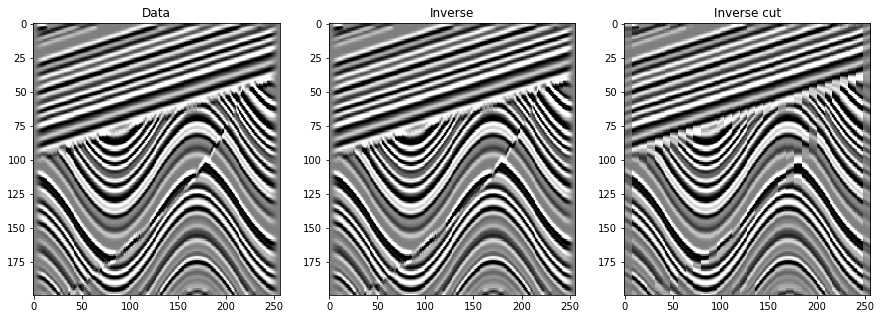

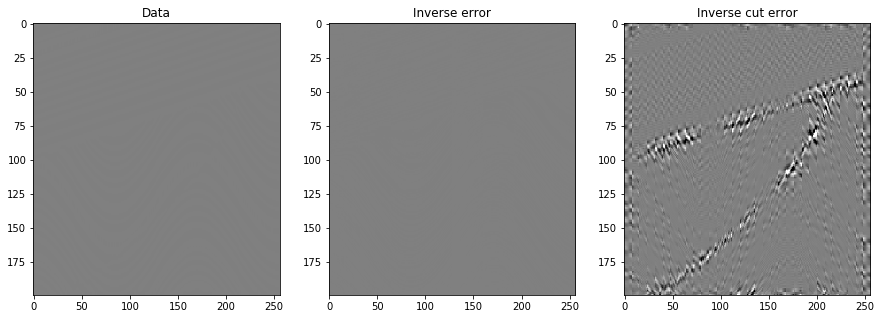

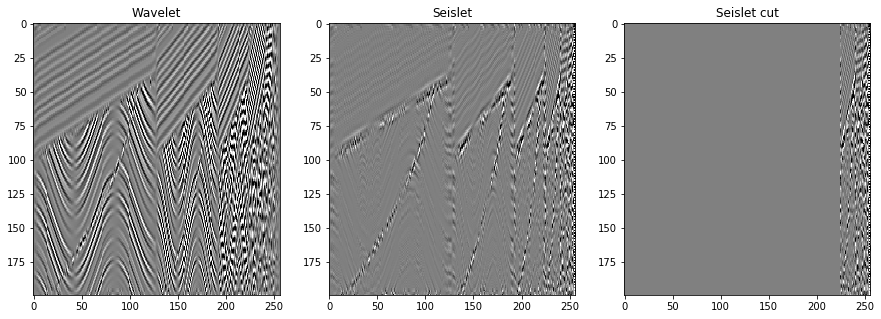

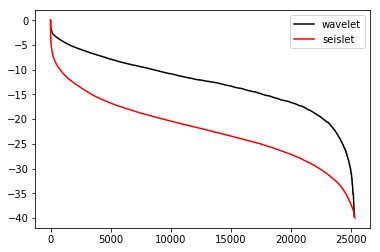

In [16]:
clip = 2e-3

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(d.T, cmap='gray', vmin=-clip, vmax=clip)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(drec.T, cmap='gray', vmin=-clip, vmax=clip)
axs[1].set_title('Inverse')
axs[1].axis('tight')
axs[2].imshow(drec1.T, cmap='gray', vmin=-clip, vmax=clip)
axs[2].set_title('Inverse cut')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(d.T, cmap='gray', vmin=-1e3, vmax=1e3)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(d.T-drec.T, cmap='gray', vmin=-clip, vmax=clip)
axs[1].set_title('Inverse error')
axs[1].axis('tight')
axs[2].imshow(d.T-drec1.T, cmap='gray', vmin=-clip, vmax=clip)
axs[2].set_title('Inverse cut error')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(dwt.T, cmap='gray', vmin=-clip, vmax=clip)
axs[0].set_title('Wavelet')
axs[0].axis('tight');
axs[1].imshow(seis.T, cmap='gray', vmin=-clip, vmax=clip)
axs[1].set_title('Seislet')
axs[1].axis('tight');
axs[2].imshow(seis1.T, cmap='gray', vmin=-clip, vmax=clip)
axs[2].set_title('Seislet cut')
axs[2].axis('tight');

dwt_sorted = np.sort(dwt.ravel())[::-1]
seis_sorted = np.sort(seis.ravel())[::-1]
dwt_sorted = dwt_sorted/dwt_sorted[0]
seis_sorted = seis_sorted/seis_sorted[0]
dwt_sorted = dwt_sorted[dwt_sorted>1e-4]
seis_sorted = seis_sorted[seis_sorted>1e-4]

plt.figure()
plt.plot((10*np.log10(dwt_sorted)), 'k', label='wavelet')
plt.plot((10*np.log10(seis_sorted)), 'r', label='seislet')
plt.legend();

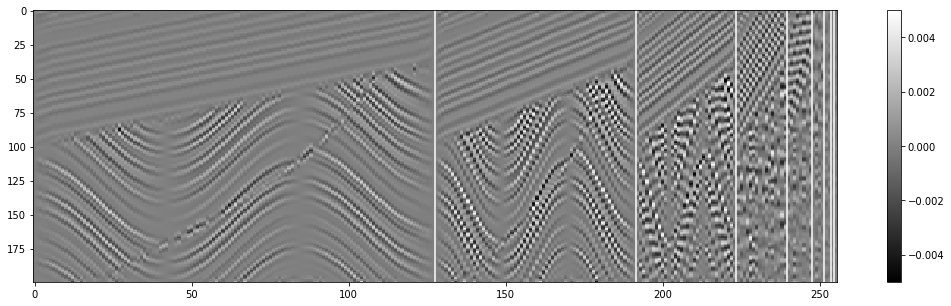

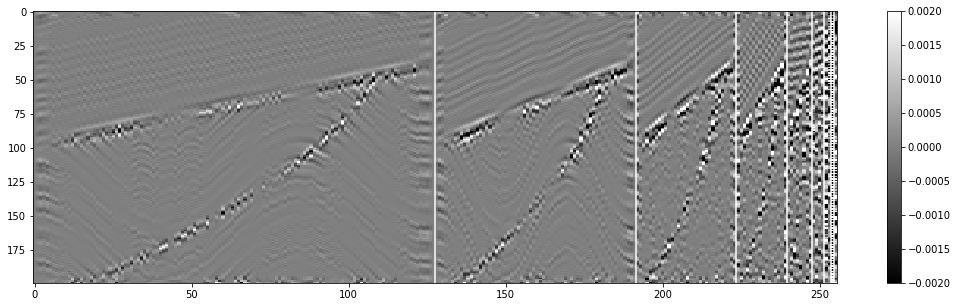

In [17]:
nlevels_max = int(np.log2(nx))
levels_size = np.flip(np.array([2 ** i for i in range(nlevels_max)]))
levels_cum = np.cumsum(levels_size)

plt.figure(figsize=(18, 5))
plt.imshow(dwt.T, cmap='gray', vmin=-0.005, vmax=0.005)
for level in levels_cum:
    plt.axvline(level-0.5, color='w')
plt.colorbar()
plt.axis('tight');

plt.figure(figsize=(18, 5))
plt.imshow(seis.T, cmap='gray', vmin=-0.002, vmax=0.002)
for level in levels_cum:
    plt.axvline(level-0.5, color='w')
plt.colorbar()
plt.axis('tight');

Compression: stored 5.320312 % samples or original


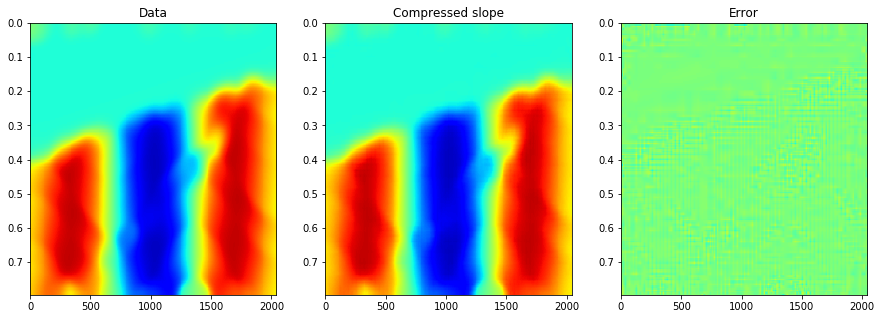

In [18]:
# 'Wavelet' transform of slope field
#dwt_slope = Wop * slope.T.ravel()
#dwt_slope = dwt_slope.reshape(nx, nt)

Wop = DWT2D((nx, nt), (0, 1), wavelet='db2', level=4)
dwt_slope = Wop * slope.T.ravel()
dwt_slope = dwt_slope.reshape(Wop.dimsd)

# Remove finer scales
ilevels = 2
#dwt_slope = dwt_slope.reshape(nx, nt)
#dwt1_slope = dwt_slope.copy()
#dwt1_slope[:levels_cum[2]] = 0
#print('Compression:', 100*(nx-levels_cum[ilevels])/nx)
#print('Compression ratio: %f' % (nx / (nx - levels_cum[ilevels])))

# Remove smaller contibutions
perc = 0.002
dwt1_slope = dwt_slope.copy()
dwt1_slope[np.abs(dwt_slope) < perc*np.max(np.abs(dwt_slope))] = 0
print('Compression: stored %f %% samples or original' % (100*(np.sum(np.abs(dwt_slope) >= perc*np.max(np.abs(dwt_slope))))/(nx*nt)))
print('Compression ratio: %f' % (nx*nt / (np.sum(np.abs(dwt_slope) >= perc*np.max(np.abs(dwt_slope))))))

#slope1 = Wop.inverse(dwt1_slope.ravel())
slope1 = Wop.H * dwt1_slope.ravel()
slope1 = slope1.reshape(nx, nt)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(slope*dx/dt, cmap='jet', vmin=-1.2, vmax=1.2,
              extent = (x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(slope1.T*dx/dt, cmap='jet', vmin=-1.2, vmax=1.2,
              extent = (x[0], x[-1], t[-1], t[0]))
axs[1].set_title('Compressed slope')
axs[1].axis('tight')
axs[2].imshow((slope-slope1.T)*dx/dt, cmap='jet', vmin=-.12, vmax=.12,
              extent = (x[0], x[-1], t[-1], t[0]))
axs[2].set_title('Error')
axs[2].axis('tight');

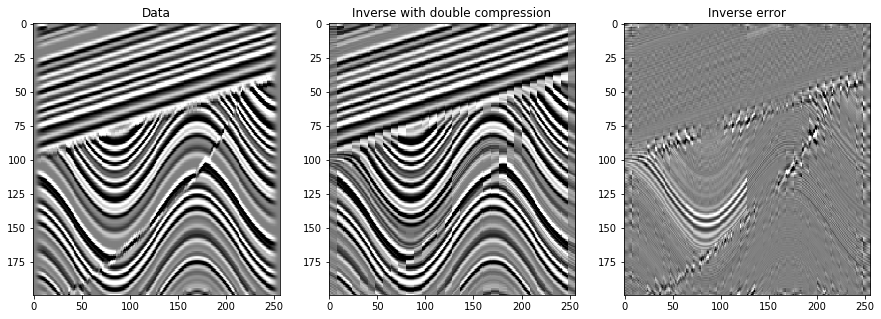

In [19]:
# Reconstruct with compressed seislet and slopes
S1op = Seislet(slope1, sampling=(dx, dt))

drec2 = S1op.inverse(seis1.ravel())
drec2 = drec2.reshape(nx, nt)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(d.T, cmap='gray', vmin=-clip, vmax=clip)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(drec2.T, cmap='gray', vmin=-clip, vmax=clip)
axs[1].set_title('Inverse with double compression')
axs[1].axis('tight')
axs[2].imshow(d.T-drec2.T, cmap='gray', vmin=-clip, vmax=clip)
axs[2].set_title('Inverse error')
axs[2].axis('tight');

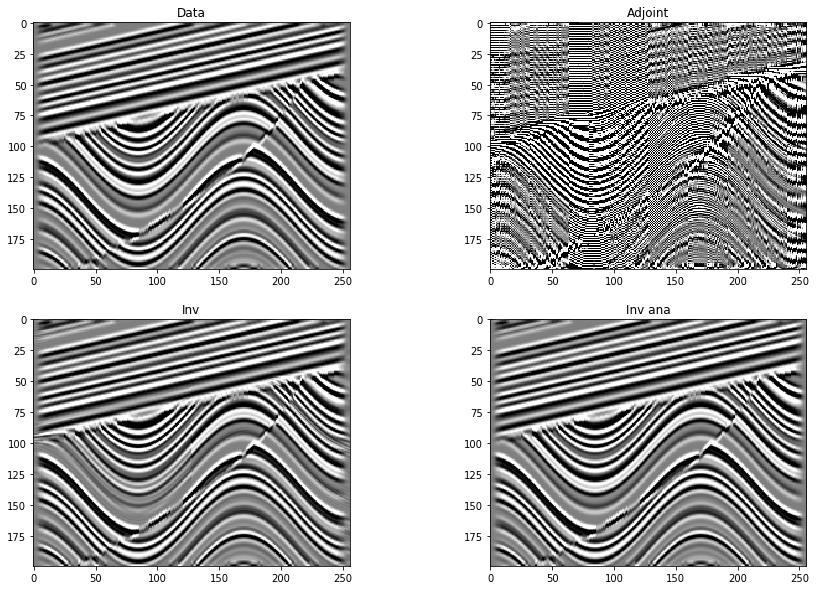

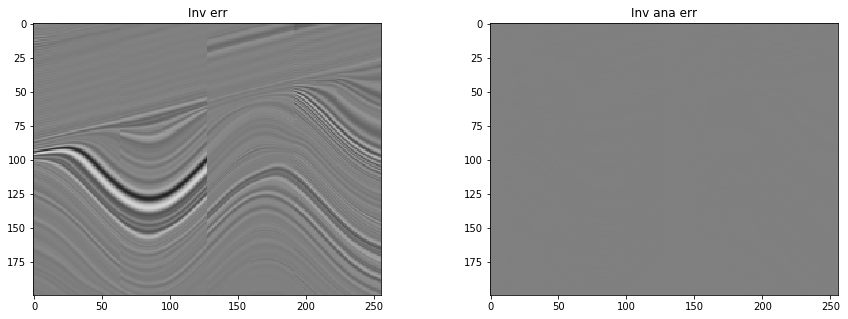

In [20]:
# Forward/adjoint/inverse
seis = Sop * d.ravel()
dadj = Sop.H * seis.ravel()
dinvana = Sop.inverse(seis.ravel())
dinv = Sop.div(seis.ravel(), niter=50)

seis = seis.reshape(nx, nt)
dadj = dadj.reshape(nx, nt)
dinvana = dinvana.reshape(nx, nt)
dinv = dinv.reshape(nx, nt)

clip = 2e-3
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].imshow(d.T, cmap='gray', vmin=-clip, vmax=clip)
axs[0][0].set_title('Data')
axs[0][1].imshow(dadj.T, cmap='gray', vmin=-clip/10, vmax=clip/10)
axs[0][1].set_title('Adjoint')
axs[1][0].imshow(dinv.T, cmap='gray', vmin=-clip, vmax=clip)
axs[1][0].set_title('Inv')
axs[1][1].imshow(dinvana.T, cmap='gray', vmin=-clip, vmax=clip)
axs[1][1].set_title('Inv ana');

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(d.T-dinv.T, cmap='gray', vmin=-clip, vmax=clip)
axs[0].set_title('Inv err')
axs[1].imshow(d.T-dinvana.T, cmap='gray', vmin=-clip, vmax=clip)
axs[1].set_title('Inv ana err');

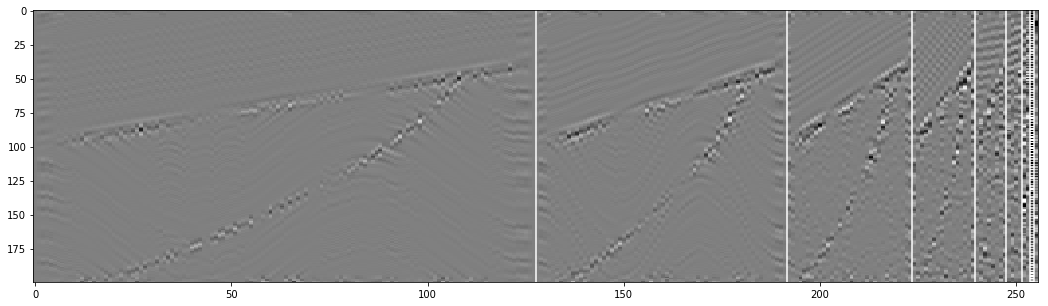

In [21]:
plt.figure(figsize=(18, 5))
plt.imshow(seis.T, cmap='gray', vmin=-0.005, vmax=0.005)
for level in levels_cum:
    plt.axvline(level-0.5, color='w')
plt.axis('tight');

# Marmousi data

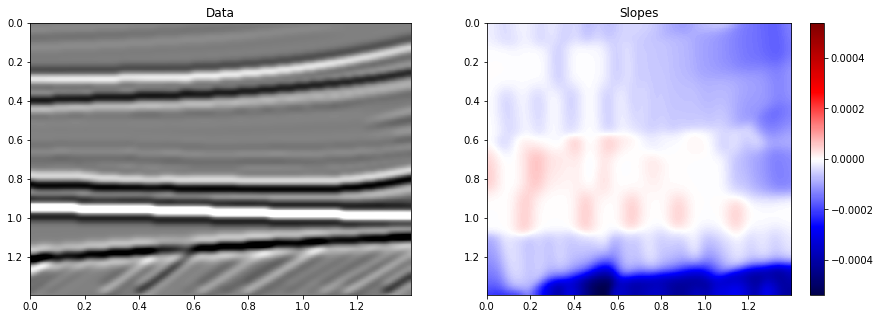

In [22]:
inputfile='../data/avo/poststack_model.npz'

model = np.load(inputfile)
m = 1000*model['model'][150:500, :2**9]
m = gaussian_filter(m, sigma=4)
nt, nx = m.shape
dt, dx = 0.004, 5.
t, x = np.arange(nt)*dt, np.arange(nt)*dt

# w = wavelet
ntwav = 31
wav = ricker(np.arange(ntwav)*0.004, 10)[0]

PPop = PoststackLinearModelling(wav, nt0=nt, spatdims=(nx,))
d = PPop*m.flatten()
d = d.reshape(nt, nx).T

# slope estimation
#slope = -slope_estimate(d.T, dt, dx, smooth=4)[0]
slope = -slope_estimate(d.T, dt, dx, smooth=13)[0]

clip = 1e3
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(d.T, cmap='gray', 
              vmin=-clip, vmax=clip,
              extent = (x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Data')
axs[0].axis('tight')
im = axs[1].imshow(slope, cmap='seismic', 
                   vmin=-np.abs(slope).max(), vmax=np.abs(slope).max(),
                   extent = (x[0], x[-1], t[-1], t[0]))
axs[1].set_title('Slopes')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1]);

Compression: stored 6.250000 % samples or original
Compression ratio: 16.000000


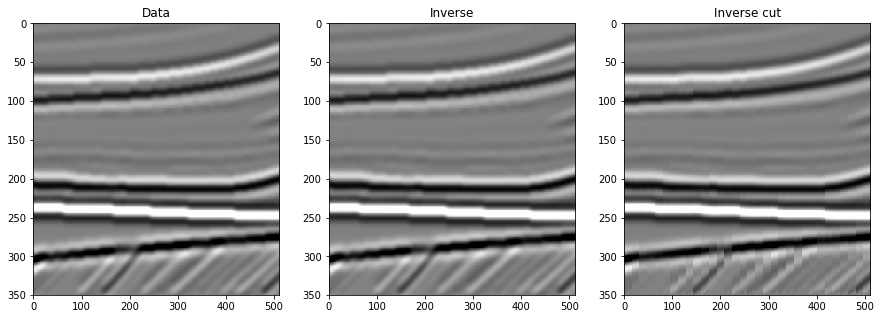

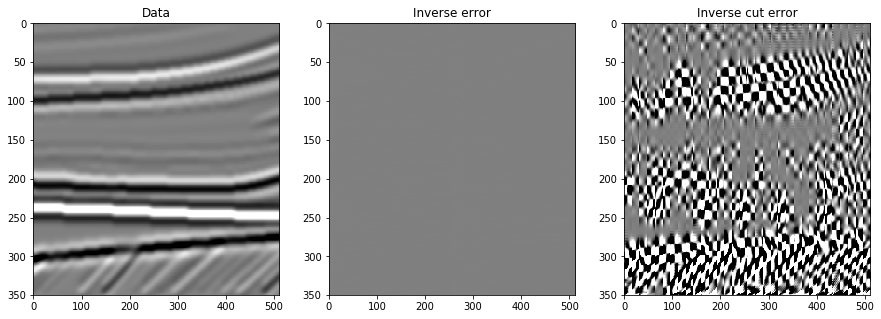

In [23]:
# Mimic Wavelet transform as Seislet without slopes
Wop = Seislet(np.zeros_like(slope.T), sampling=(dx, dt))
Sop = Seislet(slope.T, sampling=(dx, dt))

dwt = Wop * d.ravel()
seis = Sop * d.ravel()
drec = Sop.inverse(seis)

# Remove lower contibutions (ie compression)
ilevel = 3
nlevels_max = int(np.log2(nx))
levels_size = np.flip(np.array([2 ** i for i in range(nlevels_max)]))
levels_cum = np.cumsum(levels_size)
print('Compression: stored %f %% samples or original' % (100*(nx-levels_cum[ilevel])/nx))
print('Compression ratio: %f' % (nx / (nx - levels_cum[ilevel])))

seis = seis.reshape(nx, nt)
seis1 = seis.copy()
seis1[:levels_cum[ilevel]] = 0
drec1 = Sop.inverse(seis1.ravel())

dwt = dwt.reshape(nx, nt)
drec = drec.reshape(nx, nt)
drec1 = drec1.reshape(nx, nt)

clip = 1e3
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(d.T, cmap='gray', vmin=-clip, vmax=clip)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(drec.T, cmap='gray', vmin=-clip, vmax=clip)
axs[1].set_title('Inverse')
axs[1].axis('tight')
axs[2].imshow(drec1.T, cmap='gray', vmin=-clip, vmax=clip)
axs[2].set_title('Inverse cut')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(d.T, cmap='gray', vmin=-clip, vmax=clip)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(d.T-drec.T, cmap='gray', vmin=-0.01*clip, vmax=0.01*clip)
axs[1].set_title('Inverse error')
axs[1].axis('tight')
axs[2].imshow(d.T-drec1.T, cmap='gray', vmin=-0.01*clip, vmax=0.01*clip)
axs[2].set_title('Inverse cut error')
axs[2].axis('tight');

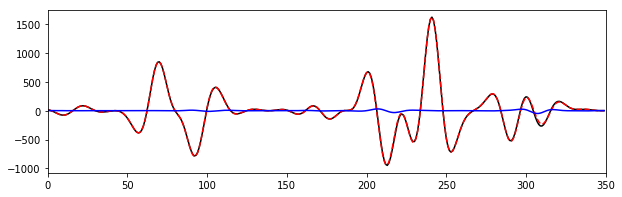

In [24]:
plt.figure(figsize=(10, 3))
plt.plot(d[200], 'k')
plt.plot(drec1[200], '--r')
plt.plot(d[200] - drec1[200], 'b')
plt.xlim(0, nt);

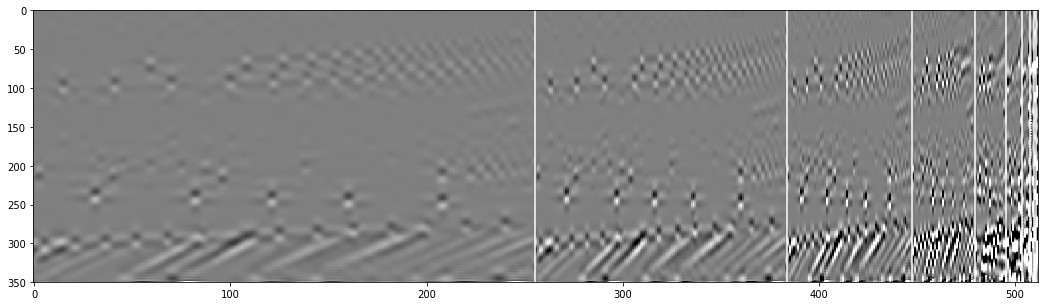

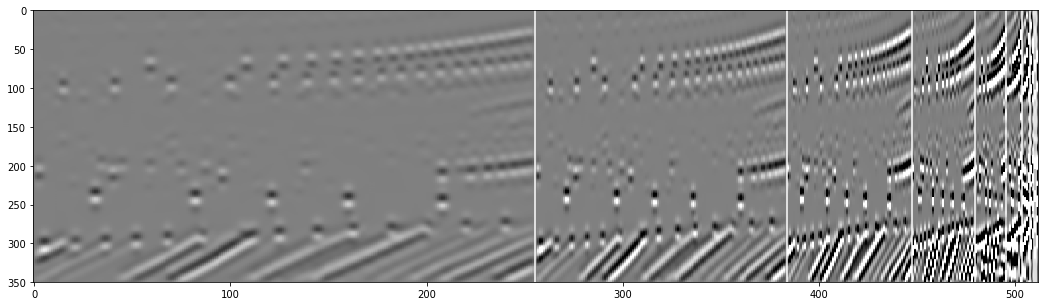

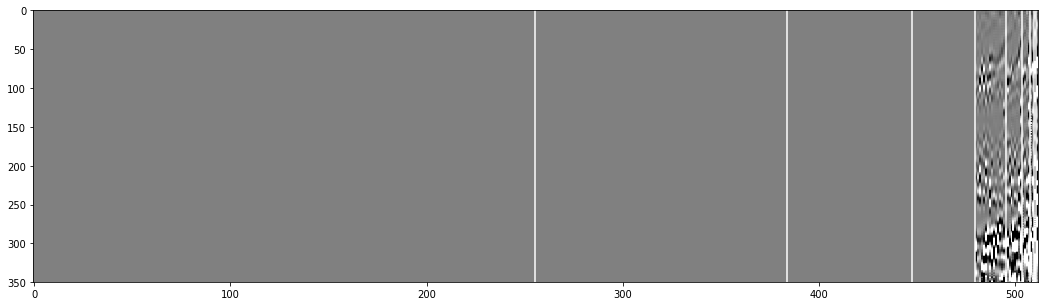

In [25]:
clips = 1e2

plt.figure(figsize=(18, 5))
plt.imshow(seis.T, cmap='gray', vmin=-clips, vmax=clips)
for level in levels_cum:
    plt.axvline(level-0.5, color='w')
plt.axis('tight')

plt.figure(figsize=(18, 5))
plt.imshow(dwt.T, cmap='gray', vmin=-clips, vmax=clips)
for level in levels_cum:
    plt.axvline(level-0.5, color='w')
plt.axis('tight')

plt.figure(figsize=(18, 5))
plt.imshow(seis1.T, cmap='gray', vmin=-clips, vmax=clips)
for level in levels_cum:
    plt.axvline(level-0.5, color='w')
plt.axis('tight');

# TO DO:

- Implement linear without adjoint.. and then with adjoin
- Understand how unit=y works (improves compression)
- Implement 3d extension using Kronecker producti